<a href="https://colab.research.google.com/github/YannTyr/Maze-generator/blob/main/Maze_v5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "drawsvg[raster]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install drawsvg

import drawsvg as draw
import math
import random
import copy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00


In [ ]:
class Maze():


    def __init__(self, rows, columns, skip_r=1, k=1, circular_bias=1, inward_bias=1):

        self.r = rows  # number of rows/circles
        self.c = columns  # number of columns/cells in the 1st row
        self.skip_r = skip_r  # size of the inner empty circle in rows
        self.k = k  # determines cell's width-hight ratio (more k – less cells)

        # Biases that determine the path-creation algorithm (default: 1 – no Bias):
        #   1. circumferential vs radial (>1 for more circular patterns) >0
        #   2. inward vs outward (>1 for more predictable spiral patterns) >0
        self.biases = (circular_bias, inward_bias)

        self.cells = self._create_grid()  # list with all cells

        #  Map opposite directions for convinience
        self.opposite_dir = {
            'up': 'down',
            'down': 'up',
            'right': 'left',
            'left': 'right',
        }


    def _create_grid(self):
        """ Returns blank maze structure (all cells have walls). """

        grid = []
        n = self.c
        for i in range(self.r):
            if n < (i + self.skip_r) * math.pi / self.k:
                n *= 2
            lst = []
            for j in range(n):
                lst.append(
                    {
                        'loc': (i, j),
                        'up': False,  #  to the centre
                        'down': False,
                        'right': False,  # counterclockwise
                        'left': False,
                    }
                )
            grid.append(lst)
        return grid


    def pave(self, loc_1, loc_2):
        """ Removes walls between 2 adjacent cells. """

        r1, a1 = loc_1
        r2, a2 = loc_2
        if r2 > r1:
            dir = 'down'
        elif r2 < r1:
            dir = 'up'
        elif (a2 > a1 and a2 - a1 == 1) or (a2 == 0 and a1 != 1):
            dir = 'left'
        else:
            dir = 'right'
        self.cells[r1][a1][dir] = True
        self.cells[r2][a2][self.opposite_dir[dir]] = True


    def _get_neighbor(self, r, a, direction):
        """ Returns adjacent cells in chosen direction. """

        neighbors = []
        ln = len(self.cells[r])
        if direction == 'up':
            if r != 0:
                ln_up = len(self.cells[r-1])
                if ln == ln_up:
                    neighbors.append(self.cells[r-1][a])
                else:
                    scale = ln // ln_up
                    az_up = a // scale
                    neighbors.append(self.cells[r-1][az_up])
        elif direction == 'down':
            if r != self.r - 1:
                ln_down = len(self.cells[r+1])
                if ln == ln_down:
                    neighbors.append(self.cells[r+1][a])
                else:
                    scale = ln_down // ln
                    for n in range(scale):
                        az_down = a * scale + n
                        neighbors.append(self.cells[r+1][az_down])
        elif direction == 'right':
            if a != 0:
                neighbors.append(self.cells[r][a-1])
            else:
                neighbors.append(self.cells[r][ln - 1])
        elif direction == 'left':
            if a + 1 != ln:
                neighbors.append(self.cells[r][a+1])
            else:
                neighbors.append(self.cells[r][0])
        else:
            print('No neighbor from ', direction, ' direction.')
        return neighbors


    def _get_neighbors(self, cell):
        """ Returns all adjacent cells. """

        r, a = cell['loc']
        neighbors = []
        paths = []
        for dir in ['up', 'down', 'right', 'left']:
            results = self._get_neighbor(r, a, dir)
            if results:
                result = results[0]
                neighbors.append(result)  # for now only 1 neighbor from each side
                if cell[dir] == True and result[self.opposite_dir[dir]] == True:
                    paths.append(result)
        return neighbors, paths


    def generate(self, method='DFS', start_loc=(0, 0), create_exit=True, end_loc=None):
        """ Creates a random maze. """

        r, a = start_loc  # radius and azimuth of the initial cell
        start_node = self.cells[r][a]
        self.cells[r][a]['up'] = True  # creates enter to the inner circle

        if method == 'DFS':
            self._depth_first_search(start_node)

        elif method == 'LERW':
            self._loop_erased_random_walk(start_node)
        # Creates an exit from the maze:
        self.pave_exit(create_exit, end_loc)


    def _depth_first_search(self, start_node):
        """
        Changing cells of the maze with Depth-First Search algorithm,
        which gives long low-branch coridors.
        """
        stack = []  # keeps cells with more than 1 neighbor
        stack.append(start_node)
        explored = []  # cells in the maze
        while True:
            if not stack:
                return
            node = stack.pop(-1)
            explored.append(node)
            neighbors, _ = self._get_neighbors(node)
            candidates = []
            for neighbor in neighbors:
                if neighbor not in explored:
                    candidates.append(neighbor)
            if candidates:
                if len(candidates) > 1:
                    stack.append(node)
                next_node = self._weighted_choise(candidates, node)
                self.pave(node['loc'], next_node['loc']) # removes walls
                stack.append(next_node)


    def _loop_erased_random_walk(self, start_node):
        """
        Changing cells of the maze with advanced Wilson's algorithm,
        which uses Loop-Erased Random Walk to make more balanced maze.
        """
        unexplored = []  # for cells unused in the maze yet
        for r in self.cells:
            for c in r:
                unexplored.append(c)
        path_start = start_node

        rand_node = random.choice(unexplored)
        unexplored.remove(rand_node)
        explored = []  # cells in the maze
        explored.append(rand_node)
        path = []  # temporal list of random-walked cells
        while unexplored:
            if path == []:
                path.append(path_start)
            node = path[-1]
            neighbors, _ = self._get_neighbors(node)
            if len(path) >= 2 and path[-2] in neighbors:
                neighbors.remove(path[-2])
            next_node = self._weighted_choise(neighbors, node)
            # Clear the path loop:
            if next_node in path:
                j = path.index(next_node)
                del path[j:]
            # Add path to the maze:
            elif next_node in explored:
                last_n = next_node
                for n in path[::-1]:
                    explored.append(n)
                    unexplored.remove(n)
                    # Remove walls between new maze cells:
                    self.pave(last_n['loc'], n['loc'])
                    last_n = n
                # Create new start for random walking:
                if unexplored:
                    path = []
                    path_start = self._weighted_choise(unexplored, next_node)
                # Maze is complete:
                else:
                    return
            # Continue the path:
            else:
                path.append(next_node)


    def _weighted_choise(self, neighbors, node):

        cir_b, inw_b = self.biases
        weights = []
        for n in neighbors:
            w = 1
            if n['loc'][0] == node['loc'][0]: # same row
                w *= cir_b
            elif n['loc'][1] < node['loc'][1]: # to the center
                w *= inw_b
            else: # to the outside
                w /= inw_b
            weights.append(w)
        next_node = random.choices(neighbors, weights, k=1)[0]
        return next_node


    def pave_exit(self, exists=True, end_loc=None):
        if not exists:
            return
        elif end_loc == None:
            exit = self._farest_cell()
            exit['down'] = True
        else:
            e_r, e_a = end_loc
            end_node = self.cells[e_r][e_a]
            cell['down'] = True


    def _farest_cell(self):
        """
        Breath-first search for the farest path
        from the start node to the outer edge.
        """
        explored = []
        stack = []
        start = self.cells[0][0]
        stack.append(start)
        while True:
            if not stack:
                for c in reversed(explored):
                    if c['loc'][0] == self.r - 1:
                        print(c['loc'][0], c)
                        return c
            cell = stack.pop(0)
            explored.append(cell)
            _, neighbors = self._get_neighbors(cell)
            for n in neighbors:
                if n not in stack and n not in explored:
                    stack.append(n)

In [ ]:
m = Maze(13, 9, 2, 0.5, 2, 1.2)
# m.generate('LERW')
m.generate('DFS')

12 {'loc': (12, 81), 'up': False, 'down': False, 'right': True, 'left': False}


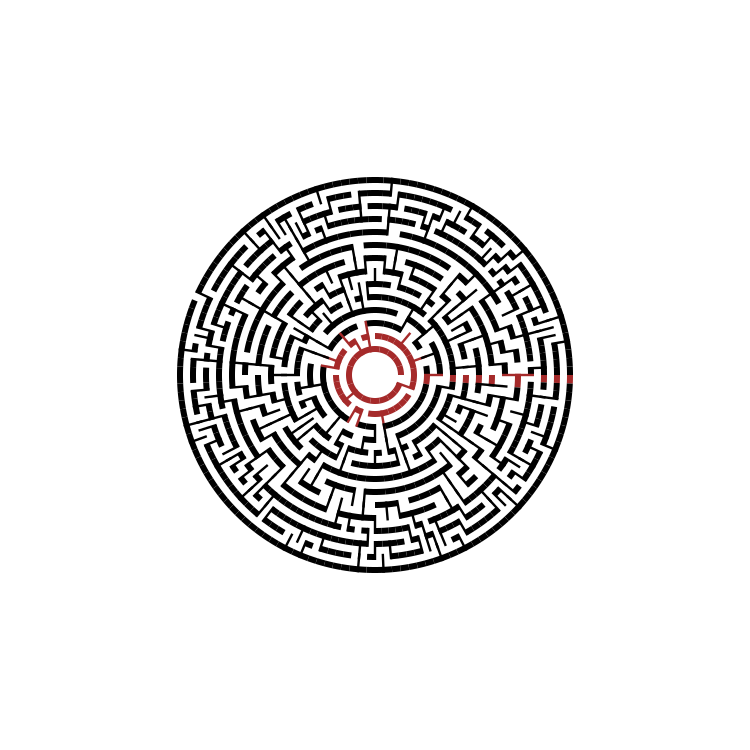

In [ ]:
w = h = 750
x = y = w / 2
row_width = 13
stroke_w = 6
d = draw.Drawing(w, h)
walls = draw.Group(
    fill='none',
    stroke='black',
    stroke_width=stroke_w
)
walls2 = draw.Group(
    fill='none',
    stroke='black',
    stroke_width=stroke_w/2.5
)

for r, row in enumerate(m.cells):
    n = len(row)
    rad = r + m.skip_r
    for a, path in enumerate(row):
        in_radius = row_width * rad
        out_radius = in_radius + row_width
        arc_lenght = 360/n
        azimuth_1 = a * arc_lenght
        azimuth_2 = azimuth_1 + arc_lenght
        if r == m.r - 1 and path['down'] == False:
            iner_arc = draw.Arc(x, y, out_radius, azimuth_2, azimuth_1)
            if a == 0:
                iner_arc = draw.Arc(x, y, out_radius, azimuth_2, azimuth_1, stroke='brown')
            walls.append(iner_arc)

        if path['up'] == False:
            arc = draw.Arc(x, y, in_radius, azimuth_2, azimuth_1)
            if a == 0 or r in [0, 1, 33, 34]:
                arc = draw.Arc(x, y, in_radius, azimuth_2, azimuth_1, stroke='brown')
            walls.append(arc)

        if path['right'] == False:
            x1 = x + (in_radius - stroke_w/2) * math.cos(math.radians(azimuth_1))
            y1 = y + (in_radius - stroke_w/2) * math.sin(math.radians(azimuth_1))
            x2 = x + (out_radius + stroke_w/2) * math.cos(math.radians(azimuth_1))
            y2 = y + (out_radius + stroke_w/2) * math.sin(math.radians(azimuth_1))
            line = draw.Lines(x1, y1, x2, y2)
            if a == 0 or r in [0, 1, 32, 33, 34]:
                line = draw.Lines(x1, y1, x2, y2, stroke='brown')

            walls2.append(line)

d.append(walls)
d.append(walls2)
# d.save_png('maze1.png')
# d.rasterize()
d